# CMA score
Mathieu Bourdenx - Oct. 2020

In [196]:
import numpy as np

+t vc 
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

In [2]:
import scanpy as sc

/opt/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [70]:
# Load cluster ID (from Seurat)

clusters = pd.read_excel('./cluster_identity.xlsx')

## Load datasets (very very long - 1hr+)

In [3]:
#Load full dataset
adata = sc.read_loom('./cx_rnaAssay.loom')

In [6]:
# Load small dataset containing cell metadata
small_adata = sc.read_loom('./cx_integratedAssay.loom')

In [13]:
# Copy metadata 
adata.obs = small_adata.obs

In [62]:
# Create a barcode dataframe

barcode = small_adata.obs

## Preprocessing 

In [21]:
# Normalize counts as CPM
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

/opt/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:1239: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(df_full[k]):


In [22]:
# Log transform data
sc.pp.log1p(adata)

## CMA score calculation

In [35]:
# Load matrix file with weight and direction 
model_matrix = pd.read_excel('./activation_model.xlsx')

In [38]:
cma_network = adata[:, model_matrix['Gene name Ms']]

In [56]:
cma_data_zs = cma_network.copy().X.todense().T

for i in tqdm(np.arange(cma_data_zs.shape[0])):
    
    µ = np.mean(cma_data_zs[i, :])
    sd = np.std(cma_data_zs[i, :])
    
    cma_data_zs[i, :] = (cma_data_zs[i, :] - µ)/sd

100%|██████████| 18/18 [00:00<00:00, 348.61it/s]


In [68]:
for i,j in tqdm(enumerate(barcode.index)):
    
    cell_matrix = model_matrix.copy()
        
    for g in cell_matrix.index:
        
        cell_matrix.loc[g, 'gene_count'] = cma_data_zs[g, i]
    
    cell_matrix['gene_score'] = cell_matrix['gene_count'] * cell_matrix['Direction'] * cell_matrix['Weight']
    score = cell_matrix['gene_score'].sum()/np.sum(cell_matrix['Weight'])
    
    barcode.loc[j, 'score'] = score

142057it [12:04, 196.08it/s]


In [87]:
for barplotin tqdm(barcode.index):
    
    barcode.loc[i, 'broad.cell.type'] = clusters.loc[int(barcode.loc[i, 'seurat_clusters']), 'broad.cell.type']

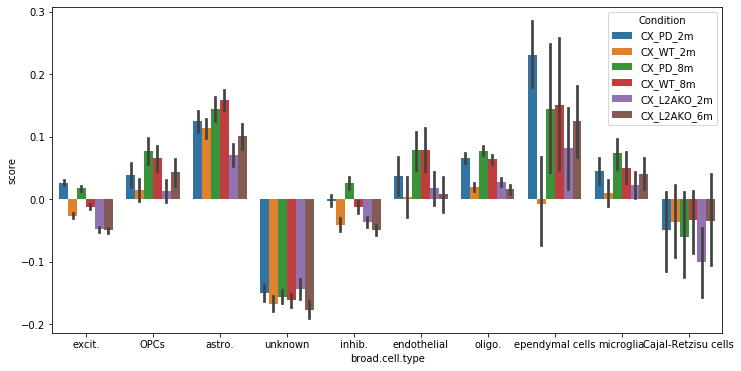

In [93]:
plt.figure(figsize=(12, 6))

sns.barplot(data=barcode, x="broad.cell.type", y='score', hue='Condition')

In [94]:
# Calculation of net score to WT 2m

for maj_cell in tqdm(np.unique(barcode['broad.cell.type'])):
    
    µ = np.mean(barcode[barcode['broad.cell.type'] == maj_cell][barcode['Condition'] == 'CX_WT_2m']['score'])
    
    for cell_index in barcode[barcode['broad.cell.type'] == maj_cell].index:
    
        barcode.loc[cell_index, 'net_score_group'] = barcode.loc[cell_index, 'score'] - µ  

  0%|          | 0/10 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 10/10 [00:47<00:00,  4.74s/it]


In [106]:
# Create a new age category to align 6 and 8m

for i in tqdm(barcode.index):
    
    if barcode.loc[i, 'Age'] == '2m': 
        barcode.loc[i, 'new_age'] = '2m'
        
    elif barcode.loc[i, 'Age'] == '6m': 
        barcode.loc[i, 'new_age'] = '8m'
        
    elif barcode.loc[i, 'Age'] == '8m': 
        barcode.loc[i, 'new_age'] = '8m'

100%|██████████| 142057/142057 [03:51<00:00, 614.96it/s]


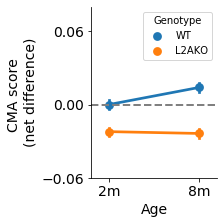

In [204]:
fig, ax = plt.subplots(figsize=(3,3), constrained_layout=True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

sns.pointplot(x='new_age', y='net_score_group', data=barcode[barcode['broad.cell.type'] == "excit."], hue='Genotype', order=['2m', '8m'] , hue_order=['WT', "L2AKO"])

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)

#plt.legend(title='Cell type', loc='upper left')
plt.ylabel('CMA score \n(net difference)', fontdict={'size': 14})
plt.xlabel('Age', fontdict={'size': 14})

plt.yticks([-0.06, 0, 0.06])

plt.ylim(-0.06, 0.08)
plt.xlim(-.2, 1.2)

plt.savefig('./plots/excitatory_net.png', dpi=300)

plt.show()

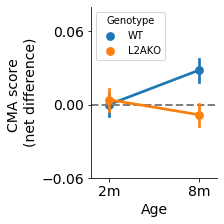

In [205]:
fig, ax = plt.subplots(figsize=(3,3), constrained_layout=True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

sns.pointplot(x='new_age', y='net_score_group', data=barcode[barcode['broad.cell.type'] == "inhib."], hue='Genotype', order=['2m', '8m'] , hue_order=['WT', "L2AKO"])

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)

#plt.legend(title='Cell type', loc='upper left')
plt.ylabel('CMA score \n(net difference)', fontdict={'size': 14})
plt.xlabel('Age', fontdict={'size': 14})

plt.yticks([-0.06, 0, 0.06])

plt.ylim(-0.06, 0.08)
plt.xlim(-.2, 1.2)

plt.savefig('./plots/inhib_net.png', dpi=300)

plt.show()

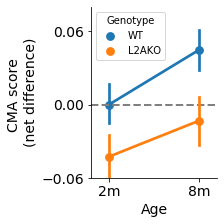

In [206]:
fig, ax = plt.subplots(figsize=(3,3), constrained_layout=True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

sns.pointplot(x='new_age', y='net_score_group', data=barcode[barcode['broad.cell.type'] == "astro."], hue='Genotype', order=['2m', '8m'] , hue_order=['WT', "L2AKO"])

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)

#plt.legend(title='Cell type', loc='upper left')
plt.ylabel('CMA score \n(net difference)', fontdict={'size': 14})
plt.xlabel('Age', fontdict={'size': 14})

plt.yticks([-0.06, 0, 0.06])

plt.ylim(-0.06, 0.08)
plt.xlim(-.2, 1.2)

plt.savefig('./plots/astro_net.png', dpi=300)

plt.show()

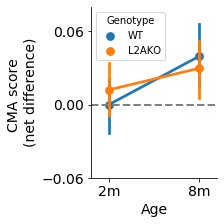

In [208]:
fig, ax = plt.subplots(figsize=(3,3), constrained_layout=True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

sns.pointplot(x='new_age', y='net_score_group', data=barcode[barcode['broad.cell.type'] == "microglia"], hue='Genotype', order=['2m', '8m'] , hue_order=['WT', "L2AKO"])

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)

#plt.legend(title='Cell type', loc='upper left')
plt.ylabel('CMA score \n(net difference)', fontdict={'size': 14})
plt.xlabel('Age', fontdict={'size': 14})

plt.yticks([-0.06, 0, 0.06])

plt.ylim(-0.06, 0.08)
plt.xlim(-.2, 1.2)

plt.savefig('./plots/microglia_net.png', dpi=300)

plt.show()

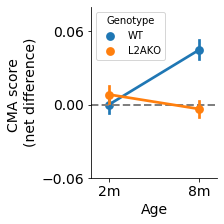

In [207]:
fig, ax = plt.subplots(figsize=(3,3), constrained_layout=True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

sns.pointplot(x='new_age', y='net_score_group', data=barcode[barcode['broad.cell.type'] == "oligo."], hue='Genotype', order=['2m', '8m'] , hue_order=['WT', "L2AKO"])

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)

#plt.legend(title='Cell type', loc='upper left')
plt.ylabel('CMA score \n(net difference)', fontdict={'size': 14})
plt.xlabel('Age', fontdict={'size': 14})

plt.yticks([-0.06, 0, 0.06])

plt.ylim(-0.06, 0.08)
plt.xlim(-.2, 1.2)

plt.savefig('./plots/oligo_net.png', dpi=300)

plt.show()

## Plots with 3 groups

In [209]:
def make_plots(cellpop): 
    
    fig, ax = plt.subplots(figsize=(4,3), constrained_layout=True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    sns.pointplot(x='new_age', y='net_score_group', data=barcode[barcode['broad.cell.type'] == cellpop], hue='Genotype', order=['2m', '8m'] , hue_order=['WT', "L2AKO", 'PD'])

    plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)

    plt.legend(bbox_to_anchor=(1,1))
    plt.ylabel('CMA score \n(net difference)', fontdict={'size': 14})
    plt.xlabel('Age', fontdict={'size': 14})

    plt.yticks([-0.06, 0, 0.06])

    plt.ylim(-0.06, 0.08)
    plt.xlim(-.2, 1.2)

    plt.savefig('./plots_3groups/{}_netscore.png'.format(cellpop), dpi=300)

    plt.show()
    

In [210]:
cell_to_plot = ['excit.', "oligo.", 'astro.', 'microglia', 'inhib.', 'OPCs']

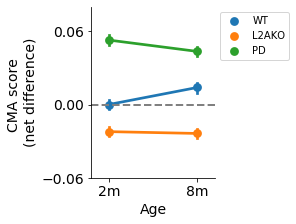

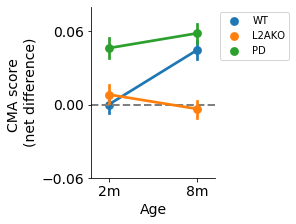

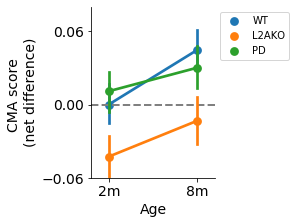

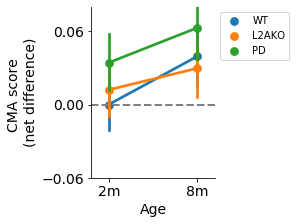

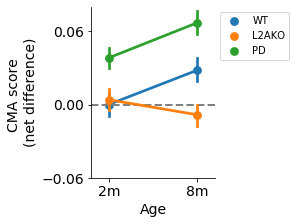

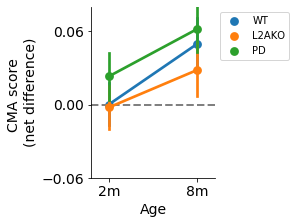

In [212]:
for i in cell_to_plot:
    make_plots(cellpop=i)

# CMA component heatmap

#### *Trial function on excitatory neurons*

In [168]:
neuron_matrix = np.zeros((18, 6))

In [170]:
wt_2m_index = list(barcode[barcode['broad.cell.type'] == 'excit.'][barcode['Genotype'] == 'WT'][barcode['new_age'] == '2m'].index)
wt_8m_index = list(barcode[barcode['broad.cell.type'] == 'excit.'][barcode['Genotype'] == 'WT'][barcode['new_age'] == '8m'].index)

ko_2m_index = list(barcode[barcode['broad.cell.type'] == 'excit.'][barcode['Genotype'] == 'L2AKO'][barcode['new_age'] == '2m'].index)
ko_8m_index = list(barcode[barcode['broad.cell.type'] == 'excit.'][barcode['Genotype'] == 'L2AKO'][barcode['new_age'] == '8m'].index)

pd_2m_index = list(barcode[barcode['broad.cell.type'] == 'excit.'][barcode['Genotype'] == 'PD'][barcode['new_age'] == '2m'].index)
pd_8m_index = list(barcode[barcode['broad.cell.type'] == 'excit.'][barcode['Genotype'] == 'PD'][barcode['new_age'] == '8m'].index)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [171]:
for rank in tqdm(np.arange(neuron_matrix.shape[0])):
    
    neuron_matrix[rank, 0] = np.mean(cma_network[wt_2m_index, :].X.todense()[:, rank])
    neuron_matrix[rank, 1] = np.mean(cma_network[wt_8m_index, :].X.todense()[:, rank])
    neuron_matrix[rank, 2] = np.mean(cma_network[ko_2m_index, :].X.todense()[:, rank])
    neuron_matrix[rank, 3] = np.mean(cma_network[ko_8m_index, :].X.todense()[:, rank])
    neuron_matrix[rank, 4] = np.mean(cma_network[pd_2m_index, :].X.todense()[:, rank])
    neuron_matrix[rank, 5] = np.mean(cma_network[pd_8m_index, :].X.todense()[:, rank])

  0%|          | 0/18 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:1239: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(df_full[k]):
/opt/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:1239: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(df_full[k]):
/opt/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:1239: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(df_full[k]):
/opt/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:1239: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(df_full[k]):
/opt/anaconda3/lib/python3.7/site-packages/anndata/core/anndat

In [172]:
neuron_matrix_zs = neuron_matrix.copy()

for i in np.arange(neuron_matrix_zs.shape[0]):
    
    µ = np.mean(neuron_matrix_zs[i, :])
    sd = np.std(neuron_matrix_zs[i, :])
    
    neuron_matrix_zs[i, :] = (neuron_matrix_zs[i, :] - µ) / sd   

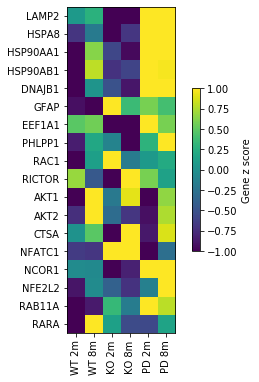

In [182]:
plt.figure(figsize=(6, 6))
plt.imshow(neuron_matrix_zs, cmap='viridis', vmin=-1, vmax=1)
plt.colorbar(shrink=.5, label='Gene z score')

plt.yticks(np.arange(18), model_matrix['Gene name'])

plt.ylim(17.5, -0.5)

plt.xticks(np.arange(6), ['WT 2m', 'WT 8m', 'KO 2m', 'KO 8m', 'PD 2m', 'PD 8m'], rotation='vertical')

plt.savefig('./heatmaps_3groups/ex_neurons.png', dpi=300)
plt.savefig('./heatmaps_3groups/ex_neurons.pdf')

plt.show()

In [183]:
neuron_matrix_2group = neuron_matrix[:, :-2]

for i in np.arange(neuron_matrix_2group.shape[0]):
    
    µ = np.mean(neuron_matrix_2group[i, :])
    sd = np.std(neuron_matrix_2group[i, :])
    
    neuron_matrix_2group[i, :] = (neuron_matrix_2group[i, :] - µ) / sd   

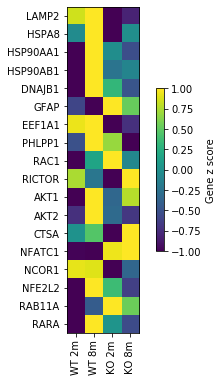

In [185]:
plt.figure(figsize=(6, 6))
plt.imshow(neuron_matrix_2group, cmap='viridis', vmin=-1, vmax=1)
plt.colorbar(shrink=.5, label='Gene z score')

plt.yticks(np.arange(18), model_matrix['Gene name'])

plt.ylim(17.5, -0.5)

plt.xticks(np.arange(4), ['WT 2m', 'WT 8m', 'KO 2m', 'KO 8m'], rotation='vertical')

plt.savefig('./heatmaps/ex_neurons.png', dpi=300)
plt.savefig('./heatmaps/ex_neurons.pdf')

plt.show()

#### *All cells function*

In [ ]:
def make_heatmaps(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((18, 6))
    
    #Find cell indices for each condition
    wt_2m_index = list(barcode[barcode['broad.cell.type'] == cellpop][barcode['Genotype'] == 'WT'][barcode['new_age'] == '2m'].index)
    wt_8m_index = list(barcode[barcode['broad.cell.type'] == cellpop][barcode['Genotype'] == 'WT'][barcode['new_age'] == '8m'].index)

    ko_2m_index = list(barcode[barcode['broad.cell.type'] == cellpop][barcode['Genotype'] == 'L2AKO'][barcode['new_age'] == '2m'].index)
    ko_8m_index = list(barcode[barcode['broad.cell.type'] == cellpop][barcode['Genotype'] == 'L2AKO'][barcode['new_age'] == '8m'].index)

    pd_2m_index = list(barcode[barcode['broad.cell.type'] == cellpop][barcode['Genotype'] == 'PD'][barcode['new_age'] == '2m'].index)
    pd_8m_index = list(barcode[barcode['broad.cell.type'] == cellpop][barcode['Genotype'] == 'PD'][barcode['new_age'] == '8m'].index)
    
    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):
    
        matrix[rank, 0] = np.mean(cma_network[wt_2m_index, :].X.todense()[:, rank])
        matrix[rank, 1] = np.mean(cma_network[wt_8m_index, :].X.todense()[:, rank])
        matrix[rank, 2] = np.mean(cma_network[ko_2m_index, :].X.todense()[:, rank])
        matrix[rank, 3] = np.mean(cma_network[ko_8m_index, :].X.todense()[:, rank])
        matrix[rank, 4] = np.mean(cma_network[pd_2m_index, :].X.todense()[:, rank])
        matrix[rank, 5] = np.mean(cma_network[pd_8m_index, :].X.todense()[:, rank])
        
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):

        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])

        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd   
        
    #Plot heatmap including all conditions
    plt.figure(figsize=(6, 6))
    plt.imshow(matrix_zs, cmap='viridis', vmin=-1, vmax=1)
    plt.colorbar(shrink=.5, label='Gene z score')

    plt.yticks(np.arange(18), model_matrix['Gene name'])

    plt.ylim(17.5, -0.5)

    plt.xticks(np.arange(6), ['WT 2m', 'WT 8m', 'KO 2m', 'KO 8m', 'PD 2m', 'PD 8m'], rotation='vertical')

    plt.savefig('./heatmaps_3groups/{}.png'.format(cellpop), dpi=300)
    plt.savefig('./heatmaps_3groups/{}.pdf'.format(cellpop))

    plt.show()
    
    
    #Perform z-scoring on only 2 groups
    
    matrix_2group = matrix[:, :-2]

    for i in np.arange(matrix_2group.shape[0]):

        µ = np.mean(matrix_2group[i, :])
        sd = np.std(matrix_2group[i, :])

        matrix_2group[i, :] = (matrix_2group[i, :] - µ) / sd   

        
    

In [191]:
cell_to_plot = ['excit.', "oligo.", 'astro.', 'microglia', 'inhib.', 'OPCs']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match Dat

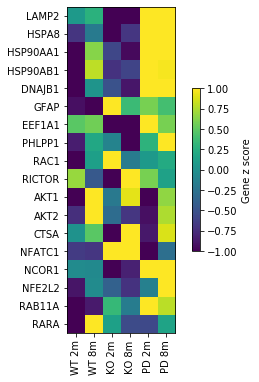

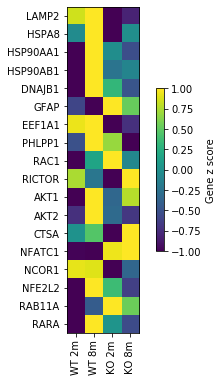

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match Dat

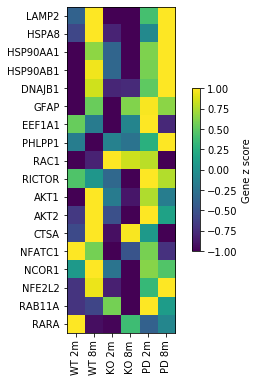

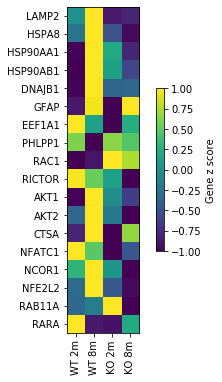

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match Dat

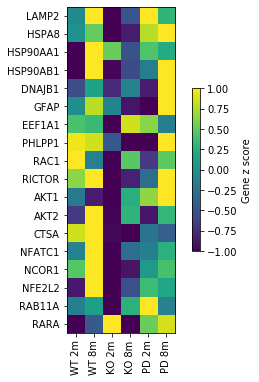

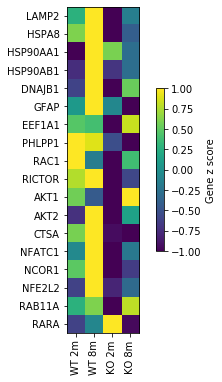

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match Dat

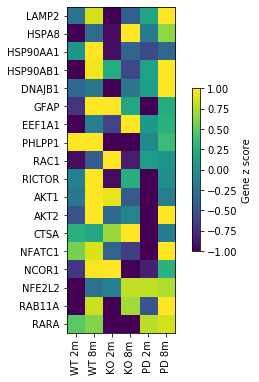

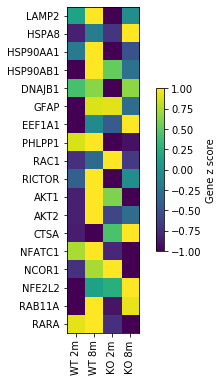

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match Dat

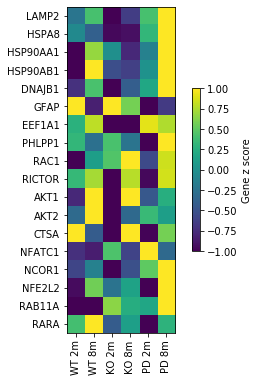

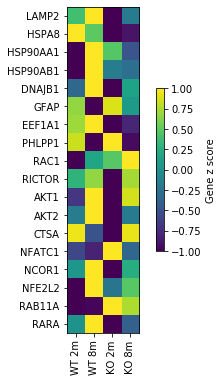

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match Dat

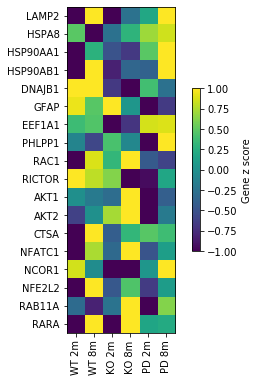

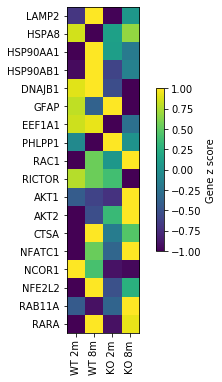

In [193]:
for i in cell_to_plot:
    make_heatmaps(cellpop=i)